In [80]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
import pickle
import random
from tqdm.auto import tqdm
import xgboost as xgb
from sklearn.metrics import accuracy_score
import optuna

train_data = pd.read_csv('dataset/fakenewstrain.csv')
for i,x in enumerate(train_data.columns):
    if i!=0:
        print(i-1,x)
test_data = pd.read_csv('dataset/fakenewstest.csv')

# Split data into features and labels
X_train = train_data.drop('label', axis=1).values
y_train = train_data['label'].values



X_test = test_data.drop('label', axis=1).values
y_test = test_data['label'].values
#print(X_train)
X_train = X_train[:,1:]
X_test = X_test[:,1:]


# replace NaN values with 0 in X
X_train = np.nan_to_num(X_train)

X_test = np.nan_to_num(X_test)


0 quotes
1 exclaim
2 allpunc
3 allcaps
4 stops
5 CC
6 CD
7 DT
8 EX
9 FW
10 IN
11 JJ
12 JJR
13 JJS
14 LS
15 MD
16 NN
17 NNS
18 NNP
19 NNPS
20 PDT
21 POS
22 PRP
23 PRP$
24 RB
25 RBR
26 RBS
27 RP
28 SYM
29 TO
30 UH
31 WP$
32 WRB
33 VB
34 VBD
35 VBG
36 VBN
37 VBP
38 VBZ
39 WDT
40 WP
41 $
42 ''
43 (
44 )
45 ,
46 --
47 .
48 :
49 ``
50 ttr
51 avg_wordlen
52 word_count
53 flesch_kincaid_grade_level
54 smog_index
55 coleman_liau_index
56 lix
57 bias_words
58 assertatives
59 factives
60 hedges
61 implicatives
62 report_verbs
63 positive_opinion_words
64 negative_opinion_words
65 vadneg
66 vadneu
67 vadpos
68 wneg
69 wpos
70 wneu
71 sneg
72 spos
73 sneu
74 HarmVirtue
75 HarmVice
76 FairnessVirtue
77 FairnessVice
78 IngroupVirtue
79 IngroupVice
80 AuthorityVirtue
81 AuthorityVice
82 PurityVirtue
83 PurityVice
84 MoralityGeneral
85 num_locations
86 num_dates
87 rich/poor
88 young/old
89 male/female stereotypes
90 rural/urban
91 white-collar/blue-collar
92 smart/dumb
93 label


In [81]:
best_score = -1
best_a = -1
best_b = -1
for i in range(1,2):
    a = random.randrange(len(X_train[0]))
    b = random.randrange(len(X_train[0]))
    X_train2 = X_train[:,[24, 22, 4, 86]]
    X_test2 = X_test[:,[24, 22, 4, 86]]
    #knn = KNeighborsClassifier(n_neighbors=i)
    #knn.fit(X_train, [1 if x > 0.5 else 0 for x in y_train])
    #predictions = knn.predict(X_test)
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                       hidden_layer_sizes=(5, 2), random_state=1)
    clf.fit(X_train2, y_train)
    predictions = clf.predict(X_test2)
    score = sum(y_test==predictions)/len(y_test)
    if score > best_score:
        best_score = score
        best_a = a
        best_b = b
print(best_a,best_b,best_score)

61 82 0.8


In [82]:
scores = []
best_score = -1
best_a = -1
best_b = -1
best_i = -1
for i in tqdm(range(1,500)):
    a = random.randrange(len(X_train[0]))
    b = random.randrange(len(X_train[0]))
    X_train2 = X_train[:,[a,b]]
    X_test2 = X_test[:,[a,b]]
    #X_train2 = X_train[:,[24, 22, 4, 86]]
    #X_test2 = X_test[:,[24, 22, 4, 86]]
    knn = KNeighborsClassifier(n_neighbors=6)
    knn.fit(X_train2, y_train)
    predictions = knn.predict(X_test2)
    score = sum(y_test==predictions)/len(y_test)
    scores.append((a,b,score))
    if score > best_score:
        best_score = score
        best_a = a
        best_b = b
        best_i = i
print(best_a,best_b,best_score)
#print(y_test)
#print(predictions)


  0%|          | 0/499 [00:00<?, ?it/s]

34 92 0.792


In [83]:
X_train2 = X_train[:,[24, 22, 4, 86]]
X_test2 = X_test[:,[24, 22, 4, 86]]
X_train2 = X_train[:,[89, 92, 4, 59, 24]]
X_test2 = X_test[:,[89, 92, 4, 59, 24]]
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train2, y_train)
predictions = knn.predict(X_test2)
print(accuracy_score(y_test, predictions))
prec = sum(y_test[y_test==0]==predictions[y_test==0])/(sum(y_test[y_test==0]==predictions[y_test==0]) + sum(y_test[predictions==0]!=predictions[predictions==0]))
with open('knnfakenews.pkl','wb') as f:
    pickle.dump(knn,f)

0.862


In [84]:
print(prec)

0.8415094339622642


In [85]:
scores.sort(key=lambda x: x[2],reverse=True)
gscores = list(filter(lambda x: x[2] >= 0.7,scores))

In [86]:
indices = [x[0] for x in gscores] + [x[1] for x in gscores]

In [87]:
counts = Counter(indices).most_common()
gcounts = list(filter(lambda x: x[1] > 2,counts))
print([x[0] for x in gcounts])

[89, 92, 4]


In [88]:

X_train2 =  X_train[:,[89, 92, 4, 59, 24]]
X_test2 =  X_test[:,[89, 92, 4, 59, 24]]
dtrain = xgb.DMatrix(X_train2, label=y_train)
dtest = xgb.DMatrix(X_test2, label=y_test)
params = {
    'objective': 'multi:softmax',  # For classification
    'num_class': 3,               # Number of classes
    'max_depth': 3,               # Tree depth
    'eta': 0.3,                   # Learning rate
    'seed': 42,                    # Random seed for reproducibility
    'gamma': 1.5
}
num_round = 50  # Number of boosting rounds
bst = xgb.train(params, dtrain, num_round)
preds = bst.predict(dtest)
accuracy = accuracy_score(y_test, preds)
print(accuracy)
#with open('knnfakenews.pkl','wb') as f:
#    pickle.dump(bst,f)

0.884


In [89]:
def objective(trial):

    params = {
        'objective': 'multi:softmax',
        'num_class': 3,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        #'gamma': trial.suggest_float('gamma', 0, 5),
        #'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }
    
    # Train model
    num_round = 50
    bst = xgb.train(params, dtrain, num_round, evals=[(dtest, "eval")], early_stopping_rounds=10)
    
    # Predict and evaluate
    preds = bst.predict(dtest)
    accuracy = accuracy_score(y_test, preds)
    
    # Return the metric to minimize/maximize
    return 1 - accuracy  # Minimize the error

In [90]:
study = optuna.create_study(direction='minimize')  # 'minimize' or 'maximize'
study.optimize(objective, n_trials=50)

[I 2024-12-02 21:55:38,589] A new study created in memory with name: no-name-4dc0b4de-f3c5-4a5e-bab4-09808d557ab8


[0]	eval-mlogloss:0.98225
[1]	eval-mlogloss:0.88605
[2]	eval-mlogloss:0.80622
[3]	eval-mlogloss:0.73996
[4]	eval-mlogloss:0.68481
[5]	eval-mlogloss:0.63767
[6]	eval-mlogloss:0.59692
[7]	eval-mlogloss:0.56440
[8]	eval-mlogloss:0.53472
[9]	eval-mlogloss:0.50927
[10]	eval-mlogloss:0.48701
[11]	eval-mlogloss:0.46876
[12]	eval-mlogloss:0.45354
[13]	eval-mlogloss:0.43994
[14]	eval-mlogloss:0.42841
[15]	eval-mlogloss:0.41804
[16]	eval-mlogloss:0.40867
[17]	eval-mlogloss:0.40010
[18]	eval-mlogloss:0.39315
[19]	eval-mlogloss:0.38696
[20]	eval-mlogloss:0.38181
[21]	eval-mlogloss:0.37597
[22]	eval-mlogloss:0.37167
[23]	eval-mlogloss:0.36876
[24]	eval-mlogloss:0.36623
[25]	eval-mlogloss:0.36401
[26]	eval-mlogloss:0.36085
[27]	eval-mlogloss:0.35955
[28]	eval-mlogloss:0.35793
[29]	eval-mlogloss:0.35536
[30]	eval-mlogloss:0.35394
[31]	eval-mlogloss:0.35302
[32]	eval-mlogloss:0.35386
[33]	eval-mlogloss:0.35317
[34]	eval-mlogloss:0.35432
[35]	eval-mlogloss:0.35397
[36]	eval-mlogloss:0.35502
[37]	eval-m

[I 2024-12-02 21:55:38,694] Trial 0 finished with value: 0.134 and parameters: {'max_depth': 10, 'eta': 0.11955038026920545}. Best is trial 0 with value: 0.134.


[0]	eval-mlogloss:0.92873
[1]	eval-mlogloss:0.80282
[2]	eval-mlogloss:0.70855
[3]	eval-mlogloss:0.63443
[4]	eval-mlogloss:0.57471
[5]	eval-mlogloss:0.52889
[6]	eval-mlogloss:0.49137
[7]	eval-mlogloss:0.46047
[8]	eval-mlogloss:0.43655
[9]	eval-mlogloss:0.41896
[10]	eval-mlogloss:0.40263
[11]	eval-mlogloss:0.38893
[12]	eval-mlogloss:0.37653
[13]	eval-mlogloss:0.36909
[14]	eval-mlogloss:0.36168
[15]	eval-mlogloss:0.35670
[16]	eval-mlogloss:0.35115
[17]	eval-mlogloss:0.34861
[18]	eval-mlogloss:0.34491
[19]	eval-mlogloss:0.34211
[20]	eval-mlogloss:0.33971
[21]	eval-mlogloss:0.33820
[22]	eval-mlogloss:0.33784
[23]	eval-mlogloss:0.33659
[24]	eval-mlogloss:0.33577
[25]	eval-mlogloss:0.33468
[26]	eval-mlogloss:0.33524
[27]	eval-mlogloss:0.33514
[28]	eval-mlogloss:0.33458
[29]	eval-mlogloss:0.33463
[30]	eval-mlogloss:0.33459
[31]	eval-mlogloss:0.33508
[32]	eval-mlogloss:0.33554
[33]	eval-mlogloss:0.33546
[34]	eval-mlogloss:0.33515
[35]	eval-mlogloss:0.33518
[36]	eval-mlogloss:0.33483
[37]	eval-m

[I 2024-12-02 21:55:38,757] Trial 1 finished with value: 0.132 and parameters: {'max_depth': 7, 'eta': 0.1776887739800657}. Best is trial 1 with value: 0.132.


[0]	eval-mlogloss:0.95042
[1]	eval-mlogloss:0.83044
[2]	eval-mlogloss:0.74054
[3]	eval-mlogloss:0.66981
[4]	eval-mlogloss:0.61230
[5]	eval-mlogloss:0.56330
[6]	eval-mlogloss:0.52234
[7]	eval-mlogloss:0.48898
[8]	eval-mlogloss:0.46106
[9]	eval-mlogloss:0.43909
[10]	eval-mlogloss:0.42054
[11]	eval-mlogloss:0.40491
[12]	eval-mlogloss:0.39076
[13]	eval-mlogloss:0.37899
[14]	eval-mlogloss:0.36999
[15]	eval-mlogloss:0.36250
[16]	eval-mlogloss:0.35551
[17]	eval-mlogloss:0.34814
[18]	eval-mlogloss:0.34187
[19]	eval-mlogloss:0.33799
[20]	eval-mlogloss:0.33292
[21]	eval-mlogloss:0.32987
[22]	eval-mlogloss:0.32615
[23]	eval-mlogloss:0.32232
[24]	eval-mlogloss:0.32021
[25]	eval-mlogloss:0.31828
[26]	eval-mlogloss:0.31640
[27]	eval-mlogloss:0.31465
[28]	eval-mlogloss:0.31430
[29]	eval-mlogloss:0.31342
[30]	eval-mlogloss:0.31337
[31]	eval-mlogloss:0.31236
[32]	eval-mlogloss:0.31198
[33]	eval-mlogloss:0.31112
[34]	eval-mlogloss:0.31081
[35]	eval-mlogloss:0.30988
[36]	eval-mlogloss:0.30933
[37]	eval-m

[I 2024-12-02 21:55:38,809] Trial 2 finished with value: 0.12 and parameters: {'max_depth': 3, 'eta': 0.16810576991477436}. Best is trial 2 with value: 0.12.


[0]	eval-mlogloss:0.89938
[1]	eval-mlogloss:0.75885
[2]	eval-mlogloss:0.66072
[3]	eval-mlogloss:0.58373
[4]	eval-mlogloss:0.52643
[5]	eval-mlogloss:0.48444
[6]	eval-mlogloss:0.45090
[7]	eval-mlogloss:0.42316
[8]	eval-mlogloss:0.40294
[9]	eval-mlogloss:0.38659
[10]	eval-mlogloss:0.37379
[11]	eval-mlogloss:0.36402
[12]	eval-mlogloss:0.35514
[13]	eval-mlogloss:0.34693
[14]	eval-mlogloss:0.34203
[15]	eval-mlogloss:0.33781
[16]	eval-mlogloss:0.33514
[17]	eval-mlogloss:0.33331
[18]	eval-mlogloss:0.33243
[19]	eval-mlogloss:0.33189
[20]	eval-mlogloss:0.33113
[21]	eval-mlogloss:0.33192
[22]	eval-mlogloss:0.33148
[23]	eval-mlogloss:0.33071
[24]	eval-mlogloss:0.33056
[25]	eval-mlogloss:0.33008
[26]	eval-mlogloss:0.32993
[27]	eval-mlogloss:0.33000
[28]	eval-mlogloss:0.32994
[29]	eval-mlogloss:0.32996
[30]	eval-mlogloss:0.32994
[31]	eval-mlogloss:0.32887
[32]	eval-mlogloss:0.32932
[33]	eval-mlogloss:0.32930
[34]	eval-mlogloss:0.33054
[35]	eval-mlogloss:0.33332
[36]	eval-mlogloss:0.33485
[37]	eval-m

[I 2024-12-02 21:55:38,879] Trial 3 finished with value: 0.118 and parameters: {'max_depth': 7, 'eta': 0.21155623094552684}. Best is trial 3 with value: 0.118.


[0]	eval-mlogloss:0.96542
[1]	eval-mlogloss:0.85831
[2]	eval-mlogloss:0.77177
[3]	eval-mlogloss:0.70242
[4]	eval-mlogloss:0.64631
[5]	eval-mlogloss:0.60098
[6]	eval-mlogloss:0.56185
[7]	eval-mlogloss:0.52875
[8]	eval-mlogloss:0.50097
[9]	eval-mlogloss:0.47742
[10]	eval-mlogloss:0.45784
[11]	eval-mlogloss:0.44222
[12]	eval-mlogloss:0.42893
[13]	eval-mlogloss:0.41716
[14]	eval-mlogloss:0.40745
[15]	eval-mlogloss:0.39895
[16]	eval-mlogloss:0.39204
[17]	eval-mlogloss:0.38501
[18]	eval-mlogloss:0.37965
[19]	eval-mlogloss:0.37352
[20]	eval-mlogloss:0.36951
[21]	eval-mlogloss:0.36619
[22]	eval-mlogloss:0.36323
[23]	eval-mlogloss:0.36057
[24]	eval-mlogloss:0.35999
[25]	eval-mlogloss:0.35892
[26]	eval-mlogloss:0.35935
[27]	eval-mlogloss:0.35992
[28]	eval-mlogloss:0.36056
[29]	eval-mlogloss:0.35972
[30]	eval-mlogloss:0.35993
[31]	eval-mlogloss:0.36084
[32]	eval-mlogloss:0.36054
[33]	eval-mlogloss:0.35998
[34]	eval-mlogloss:0.36099


[I 2024-12-02 21:55:38,964] Trial 4 finished with value: 0.14400000000000002 and parameters: {'max_depth': 10, 'eta': 0.1379491240518699}. Best is trial 3 with value: 0.118.


[0]	eval-mlogloss:1.05055
[1]	eval-mlogloss:1.00628
[2]	eval-mlogloss:0.96475
[3]	eval-mlogloss:0.92560
[4]	eval-mlogloss:0.88956
[5]	eval-mlogloss:0.85587
[6]	eval-mlogloss:0.82523
[7]	eval-mlogloss:0.79667
[8]	eval-mlogloss:0.77009
[9]	eval-mlogloss:0.74454
[10]	eval-mlogloss:0.72128
[11]	eval-mlogloss:0.70002
[12]	eval-mlogloss:0.67946
[13]	eval-mlogloss:0.66045
[14]	eval-mlogloss:0.64218
[15]	eval-mlogloss:0.62465
[16]	eval-mlogloss:0.60763
[17]	eval-mlogloss:0.59177
[18]	eval-mlogloss:0.57675
[19]	eval-mlogloss:0.56273
[20]	eval-mlogloss:0.55030
[21]	eval-mlogloss:0.53812
[22]	eval-mlogloss:0.52655
[23]	eval-mlogloss:0.51538
[24]	eval-mlogloss:0.50553
[25]	eval-mlogloss:0.49588
[26]	eval-mlogloss:0.48700
[27]	eval-mlogloss:0.47858
[28]	eval-mlogloss:0.47029
[29]	eval-mlogloss:0.46298
[30]	eval-mlogloss:0.45556
[31]	eval-mlogloss:0.44856
[32]	eval-mlogloss:0.44199
[33]	eval-mlogloss:0.43579
[34]	eval-mlogloss:0.42999
[35]	eval-mlogloss:0.42461
[36]	eval-mlogloss:0.41930
[37]	eval-m

[I 2024-12-02 21:55:39,045] Trial 5 finished with value: 0.122 and parameters: {'max_depth': 6, 'eta': 0.04805745616401887}. Best is trial 3 with value: 0.118.


[0]	eval-mlogloss:1.01191
[1]	eval-mlogloss:0.93686
[2]	eval-mlogloss:0.87170
[3]	eval-mlogloss:0.81450
[4]	eval-mlogloss:0.76488
[5]	eval-mlogloss:0.72085
[6]	eval-mlogloss:0.68153
[7]	eval-mlogloss:0.64622
[8]	eval-mlogloss:0.61400
[9]	eval-mlogloss:0.58480
[10]	eval-mlogloss:0.55904
[11]	eval-mlogloss:0.53631
[12]	eval-mlogloss:0.51598
[13]	eval-mlogloss:0.49789
[14]	eval-mlogloss:0.48128
[15]	eval-mlogloss:0.46688
[16]	eval-mlogloss:0.45313
[17]	eval-mlogloss:0.44170
[18]	eval-mlogloss:0.43088
[19]	eval-mlogloss:0.42123
[20]	eval-mlogloss:0.41266
[21]	eval-mlogloss:0.40462
[22]	eval-mlogloss:0.39714
[23]	eval-mlogloss:0.39027
[24]	eval-mlogloss:0.38371
[25]	eval-mlogloss:0.37747
[26]	eval-mlogloss:0.37208
[27]	eval-mlogloss:0.36701
[28]	eval-mlogloss:0.36265
[29]	eval-mlogloss:0.35896
[30]	eval-mlogloss:0.35599
[31]	eval-mlogloss:0.35244
[32]	eval-mlogloss:0.34989
[33]	eval-mlogloss:0.34697
[34]	eval-mlogloss:0.34483
[35]	eval-mlogloss:0.34293
[36]	eval-mlogloss:0.34110
[37]	eval-m

[I 2024-12-02 21:55:39,116] Trial 6 finished with value: 0.126 and parameters: {'max_depth': 5, 'eta': 0.08774670112574177}. Best is trial 3 with value: 0.118.


[0]	eval-mlogloss:0.92593
[1]	eval-mlogloss:0.79262
[2]	eval-mlogloss:0.69699
[3]	eval-mlogloss:0.62270
[4]	eval-mlogloss:0.56412
[5]	eval-mlogloss:0.51789
[6]	eval-mlogloss:0.47941
[7]	eval-mlogloss:0.45075
[8]	eval-mlogloss:0.42682
[9]	eval-mlogloss:0.40667
[10]	eval-mlogloss:0.39041
[11]	eval-mlogloss:0.37568
[12]	eval-mlogloss:0.36498
[13]	eval-mlogloss:0.35609
[14]	eval-mlogloss:0.34899
[15]	eval-mlogloss:0.34209
[16]	eval-mlogloss:0.33648
[17]	eval-mlogloss:0.33188
[18]	eval-mlogloss:0.32749
[19]	eval-mlogloss:0.32396
[20]	eval-mlogloss:0.32101
[21]	eval-mlogloss:0.31930
[22]	eval-mlogloss:0.31682
[23]	eval-mlogloss:0.31521
[24]	eval-mlogloss:0.31466
[25]	eval-mlogloss:0.31283
[26]	eval-mlogloss:0.31184
[27]	eval-mlogloss:0.31193
[28]	eval-mlogloss:0.31100
[29]	eval-mlogloss:0.31018
[30]	eval-mlogloss:0.30959
[31]	eval-mlogloss:0.30952
[32]	eval-mlogloss:0.30960
[33]	eval-mlogloss:0.30897
[34]	eval-mlogloss:0.30830
[35]	eval-mlogloss:0.30824
[36]	eval-mlogloss:0.30842
[37]	eval-m

[I 2024-12-02 21:55:39,168] Trial 7 finished with value: 0.122 and parameters: {'max_depth': 3, 'eta': 0.19840567688088634}. Best is trial 3 with value: 0.118.


[0]	eval-mlogloss:0.88887
[1]	eval-mlogloss:0.74366
[2]	eval-mlogloss:0.64123
[3]	eval-mlogloss:0.56995
[4]	eval-mlogloss:0.51491
[5]	eval-mlogloss:0.47476
[6]	eval-mlogloss:0.44380
[7]	eval-mlogloss:0.42298
[8]	eval-mlogloss:0.40663
[9]	eval-mlogloss:0.39205
[10]	eval-mlogloss:0.38011
[11]	eval-mlogloss:0.37116
[12]	eval-mlogloss:0.36438
[13]	eval-mlogloss:0.36039
[14]	eval-mlogloss:0.35636
[15]	eval-mlogloss:0.35443
[16]	eval-mlogloss:0.35321
[17]	eval-mlogloss:0.35484
[18]	eval-mlogloss:0.35699
[19]	eval-mlogloss:0.35674
[20]	eval-mlogloss:0.35542
[21]	eval-mlogloss:0.35571
[22]	eval-mlogloss:0.35471
[23]	eval-mlogloss:0.35537
[24]	eval-mlogloss:0.35630
[25]	eval-mlogloss:0.35807


[I 2024-12-02 21:55:39,232] Trial 8 finished with value: 0.138 and parameters: {'max_depth': 10, 'eta': 0.22613407465478183}. Best is trial 3 with value: 0.118.


[0]	eval-mlogloss:1.06396
[1]	eval-mlogloss:1.03068
[2]	eval-mlogloss:0.99925
[3]	eval-mlogloss:0.96935
[4]	eval-mlogloss:0.94153
[5]	eval-mlogloss:0.91483
[6]	eval-mlogloss:0.89014
[7]	eval-mlogloss:0.86613
[8]	eval-mlogloss:0.84380
[9]	eval-mlogloss:0.82182
[10]	eval-mlogloss:0.80123
[11]	eval-mlogloss:0.78173
[12]	eval-mlogloss:0.76270
[13]	eval-mlogloss:0.74514
[14]	eval-mlogloss:0.72787
[15]	eval-mlogloss:0.71143
[16]	eval-mlogloss:0.69629
[17]	eval-mlogloss:0.68116
[18]	eval-mlogloss:0.66719
[19]	eval-mlogloss:0.65337
[20]	eval-mlogloss:0.64041
[21]	eval-mlogloss:0.62785
[22]	eval-mlogloss:0.61598
[23]	eval-mlogloss:0.60490
[24]	eval-mlogloss:0.59374
[25]	eval-mlogloss:0.58365
[26]	eval-mlogloss:0.57305
[27]	eval-mlogloss:0.56331
[28]	eval-mlogloss:0.55402
[29]	eval-mlogloss:0.54525
[30]	eval-mlogloss:0.53624
[31]	eval-mlogloss:0.52841
[32]	eval-mlogloss:0.52014
[33]	eval-mlogloss:0.51243
[34]	eval-mlogloss:0.50508
[35]	eval-mlogloss:0.49823
[36]	eval-mlogloss:0.49147
[37]	eval-m

[I 2024-12-02 21:55:39,295] Trial 9 finished with value: 0.11199999999999999 and parameters: {'max_depth': 4, 'eta': 0.03536946522975382}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:0.83132
[1]	eval-mlogloss:0.67203
[2]	eval-mlogloss:0.56497
[3]	eval-mlogloss:0.49311
[4]	eval-mlogloss:0.44449
[5]	eval-mlogloss:0.40933
[6]	eval-mlogloss:0.38583
[7]	eval-mlogloss:0.36837
[8]	eval-mlogloss:0.35554
[9]	eval-mlogloss:0.34766
[10]	eval-mlogloss:0.34204
[11]	eval-mlogloss:0.33728
[12]	eval-mlogloss:0.33520
[13]	eval-mlogloss:0.33276
[14]	eval-mlogloss:0.32957
[15]	eval-mlogloss:0.32720
[16]	eval-mlogloss:0.32578
[17]	eval-mlogloss:0.32486
[18]	eval-mlogloss:0.32370
[19]	eval-mlogloss:0.32304
[20]	eval-mlogloss:0.32316
[21]	eval-mlogloss:0.32277
[22]	eval-mlogloss:0.32292
[23]	eval-mlogloss:0.32258
[24]	eval-mlogloss:0.32330
[25]	eval-mlogloss:0.32321
[26]	eval-mlogloss:0.32258
[27]	eval-mlogloss:0.32168
[28]	eval-mlogloss:0.32321
[29]	eval-mlogloss:0.32363
[30]	eval-mlogloss:0.32523
[31]	eval-mlogloss:0.32751
[32]	eval-mlogloss:0.32823
[33]	eval-mlogloss:0.32971
[34]	eval-mlogloss:0.33090
[35]	eval-mlogloss:0.33307
[36]	eval-mlogloss:0.33239


[I 2024-12-02 21:55:39,351] Trial 10 finished with value: 0.128 and parameters: {'max_depth': 5, 'eta': 0.2957948535161682}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:1.07022
[1]	eval-mlogloss:1.04321
[2]	eval-mlogloss:1.01727
[3]	eval-mlogloss:0.99199
[4]	eval-mlogloss:0.96787
[5]	eval-mlogloss:0.94465
[6]	eval-mlogloss:0.92267
[7]	eval-mlogloss:0.90120
[8]	eval-mlogloss:0.88084
[9]	eval-mlogloss:0.86149
[10]	eval-mlogloss:0.84286
[11]	eval-mlogloss:0.82518
[12]	eval-mlogloss:0.80770
[13]	eval-mlogloss:0.79156
[14]	eval-mlogloss:0.77571
[15]	eval-mlogloss:0.76071
[16]	eval-mlogloss:0.74646
[17]	eval-mlogloss:0.73261
[18]	eval-mlogloss:0.71931
[19]	eval-mlogloss:0.70642
[20]	eval-mlogloss:0.69402
[21]	eval-mlogloss:0.68218
[22]	eval-mlogloss:0.67068
[23]	eval-mlogloss:0.65979
[24]	eval-mlogloss:0.64922
[25]	eval-mlogloss:0.63885
[26]	eval-mlogloss:0.62918
[27]	eval-mlogloss:0.61953
[28]	eval-mlogloss:0.61017
[29]	eval-mlogloss:0.60108
[30]	eval-mlogloss:0.59240
[31]	eval-mlogloss:0.58421
[32]	eval-mlogloss:0.57621
[33]	eval-mlogloss:0.56871
[34]	eval-mlogloss:0.56151
[35]	eval-mlogloss:0.55403
[36]	eval-mlogloss:0.54691
[37]	eval-m

[I 2024-12-02 21:55:39,463] Trial 11 finished with value: 0.13 and parameters: {'max_depth': 8, 'eta': 0.028267819496433755}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:0.86696
[1]	eval-mlogloss:0.71188
[2]	eval-mlogloss:0.60563
[3]	eval-mlogloss:0.53416
[4]	eval-mlogloss:0.48455
[5]	eval-mlogloss:0.44575
[6]	eval-mlogloss:0.41412
[7]	eval-mlogloss:0.39244
[8]	eval-mlogloss:0.37656
[9]	eval-mlogloss:0.36355
[10]	eval-mlogloss:0.35361
[11]	eval-mlogloss:0.34896
[12]	eval-mlogloss:0.34465
[13]	eval-mlogloss:0.34198
[14]	eval-mlogloss:0.33947
[15]	eval-mlogloss:0.33752
[16]	eval-mlogloss:0.33739
[17]	eval-mlogloss:0.33762
[18]	eval-mlogloss:0.33706
[19]	eval-mlogloss:0.33748
[20]	eval-mlogloss:0.33705
[21]	eval-mlogloss:0.33747
[22]	eval-mlogloss:0.33787
[23]	eval-mlogloss:0.33802
[24]	eval-mlogloss:0.33855
[25]	eval-mlogloss:0.33884
[26]	eval-mlogloss:0.33920
[27]	eval-mlogloss:0.34047
[28]	eval-mlogloss:0.34233
[29]	eval-mlogloss:0.34466
[30]	eval-mlogloss:0.34777


[I 2024-12-02 21:55:39,526] Trial 12 finished with value: 0.14400000000000002 and parameters: {'max_depth': 8, 'eta': 0.2547834801315003}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:1.01961
[1]	eval-mlogloss:0.94892
[2]	eval-mlogloss:0.88781
[3]	eval-mlogloss:0.83279
[4]	eval-mlogloss:0.78526
[5]	eval-mlogloss:0.74145
[6]	eval-mlogloss:0.70269
[7]	eval-mlogloss:0.66888
[8]	eval-mlogloss:0.63845
[9]	eval-mlogloss:0.60929
[10]	eval-mlogloss:0.58360
[11]	eval-mlogloss:0.56016
[12]	eval-mlogloss:0.53939
[13]	eval-mlogloss:0.51982
[14]	eval-mlogloss:0.50235
[15]	eval-mlogloss:0.48716
[16]	eval-mlogloss:0.47254
[17]	eval-mlogloss:0.45927
[18]	eval-mlogloss:0.44724
[19]	eval-mlogloss:0.43592
[20]	eval-mlogloss:0.42584
[21]	eval-mlogloss:0.41677
[22]	eval-mlogloss:0.40894
[23]	eval-mlogloss:0.40115
[24]	eval-mlogloss:0.39458
[25]	eval-mlogloss:0.38786
[26]	eval-mlogloss:0.38183
[27]	eval-mlogloss:0.37655
[28]	eval-mlogloss:0.37149
[29]	eval-mlogloss:0.36696
[30]	eval-mlogloss:0.36252
[31]	eval-mlogloss:0.35910
[32]	eval-mlogloss:0.35560
[33]	eval-mlogloss:0.35233
[34]	eval-mlogloss:0.34945
[35]	eval-mlogloss:0.34676
[36]	eval-mlogloss:0.34386
[37]	eval-m

[I 2024-12-02 21:55:39,597] Trial 13 finished with value: 0.118 and parameters: {'max_depth': 4, 'eta': 0.08210074277972212}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:0.87553
[1]	eval-mlogloss:0.72589
[2]	eval-mlogloss:0.62359
[3]	eval-mlogloss:0.54816
[4]	eval-mlogloss:0.49574
[5]	eval-mlogloss:0.45597
[6]	eval-mlogloss:0.42369
[7]	eval-mlogloss:0.40310
[8]	eval-mlogloss:0.38384
[9]	eval-mlogloss:0.36898
[10]	eval-mlogloss:0.35825
[11]	eval-mlogloss:0.35214
[12]	eval-mlogloss:0.34859
[13]	eval-mlogloss:0.34360
[14]	eval-mlogloss:0.34166
[15]	eval-mlogloss:0.34101
[16]	eval-mlogloss:0.33987
[17]	eval-mlogloss:0.33939
[18]	eval-mlogloss:0.34104
[19]	eval-mlogloss:0.34113
[20]	eval-mlogloss:0.34126
[21]	eval-mlogloss:0.34049
[22]	eval-mlogloss:0.34087
[23]	eval-mlogloss:0.34022
[24]	eval-mlogloss:0.34026
[25]	eval-mlogloss:0.33945
[26]	eval-mlogloss:0.34049
[27]	eval-mlogloss:0.34057


[I 2024-12-02 21:55:39,654] Trial 14 finished with value: 0.132 and parameters: {'max_depth': 7, 'eta': 0.23995352286348065}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:0.99171
[1]	eval-mlogloss:0.90305
[2]	eval-mlogloss:0.82765
[3]	eval-mlogloss:0.76431
[4]	eval-mlogloss:0.71024
[5]	eval-mlogloss:0.66334
[6]	eval-mlogloss:0.62161
[7]	eval-mlogloss:0.58620
[8]	eval-mlogloss:0.55429
[9]	eval-mlogloss:0.52657
[10]	eval-mlogloss:0.50368
[11]	eval-mlogloss:0.48280
[12]	eval-mlogloss:0.46437
[13]	eval-mlogloss:0.44877
[14]	eval-mlogloss:0.43388
[15]	eval-mlogloss:0.42143
[16]	eval-mlogloss:0.41100
[17]	eval-mlogloss:0.40187
[18]	eval-mlogloss:0.39337
[19]	eval-mlogloss:0.38606
[20]	eval-mlogloss:0.37875
[21]	eval-mlogloss:0.37186
[22]	eval-mlogloss:0.36674
[23]	eval-mlogloss:0.36215
[24]	eval-mlogloss:0.35821
[25]	eval-mlogloss:0.35443
[26]	eval-mlogloss:0.35073
[27]	eval-mlogloss:0.34760
[28]	eval-mlogloss:0.34567
[29]	eval-mlogloss:0.34345
[30]	eval-mlogloss:0.34195
[31]	eval-mlogloss:0.33986
[32]	eval-mlogloss:0.33863
[33]	eval-mlogloss:0.33710
[34]	eval-mlogloss:0.33522
[35]	eval-mlogloss:0.33420
[36]	eval-mlogloss:0.33277
[37]	eval-m

[I 2024-12-02 21:55:39,732] Trial 15 finished with value: 0.124 and parameters: {'max_depth': 5, 'eta': 0.10912977364394845}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:0.90879
[1]	eval-mlogloss:0.77084
[2]	eval-mlogloss:0.67373
[3]	eval-mlogloss:0.59923
[4]	eval-mlogloss:0.54132
[5]	eval-mlogloss:0.49822
[6]	eval-mlogloss:0.46341
[7]	eval-mlogloss:0.43682
[8]	eval-mlogloss:0.41505
[9]	eval-mlogloss:0.39976
[10]	eval-mlogloss:0.38587
[11]	eval-mlogloss:0.37563
[12]	eval-mlogloss:0.36587
[13]	eval-mlogloss:0.35849
[14]	eval-mlogloss:0.35537
[15]	eval-mlogloss:0.35165
[16]	eval-mlogloss:0.34818
[17]	eval-mlogloss:0.34566
[18]	eval-mlogloss:0.34552
[19]	eval-mlogloss:0.34421
[20]	eval-mlogloss:0.34321
[21]	eval-mlogloss:0.34169
[22]	eval-mlogloss:0.34190
[23]	eval-mlogloss:0.34193
[24]	eval-mlogloss:0.34306
[25]	eval-mlogloss:0.34314
[26]	eval-mlogloss:0.34624
[27]	eval-mlogloss:0.34669
[28]	eval-mlogloss:0.34665
[29]	eval-mlogloss:0.34713
[30]	eval-mlogloss:0.34649
[31]	eval-mlogloss:0.34702


[I 2024-12-02 21:55:39,801] Trial 16 finished with value: 0.122 and parameters: {'max_depth': 8, 'eta': 0.20388095930638242}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:1.08431
[1]	eval-mlogloss:1.07034
[2]	eval-mlogloss:1.05667
[3]	eval-mlogloss:1.04344
[4]	eval-mlogloss:1.03041
[5]	eval-mlogloss:1.01729
[6]	eval-mlogloss:1.00456
[7]	eval-mlogloss:0.99206
[8]	eval-mlogloss:0.97989
[9]	eval-mlogloss:0.96796
[10]	eval-mlogloss:0.95636
[11]	eval-mlogloss:0.94497
[12]	eval-mlogloss:0.93383
[13]	eval-mlogloss:0.92278
[14]	eval-mlogloss:0.91220
[15]	eval-mlogloss:0.90171
[16]	eval-mlogloss:0.89154
[17]	eval-mlogloss:0.88144
[18]	eval-mlogloss:0.87170
[19]	eval-mlogloss:0.86220
[20]	eval-mlogloss:0.85281
[21]	eval-mlogloss:0.84375
[22]	eval-mlogloss:0.83486
[23]	eval-mlogloss:0.82617
[24]	eval-mlogloss:0.81749
[25]	eval-mlogloss:0.80911
[26]	eval-mlogloss:0.80086
[27]	eval-mlogloss:0.79282
[28]	eval-mlogloss:0.78493
[29]	eval-mlogloss:0.77710
[30]	eval-mlogloss:0.76951
[31]	eval-mlogloss:0.76207
[32]	eval-mlogloss:0.75475
[33]	eval-mlogloss:0.74766
[34]	eval-mlogloss:0.74059
[35]	eval-mlogloss:0.73383
[36]	eval-mlogloss:0.72705
[37]	eval-m

[I 2024-12-02 21:55:39,900] Trial 17 finished with value: 0.118 and parameters: {'max_depth': 6, 'eta': 0.014110684147863192}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:0.84958
[1]	eval-mlogloss:0.68945
[2]	eval-mlogloss:0.58297
[3]	eval-mlogloss:0.51103
[4]	eval-mlogloss:0.46020
[5]	eval-mlogloss:0.42228
[6]	eval-mlogloss:0.39648
[7]	eval-mlogloss:0.37706
[8]	eval-mlogloss:0.36212
[9]	eval-mlogloss:0.34996
[10]	eval-mlogloss:0.34041
[11]	eval-mlogloss:0.33566
[12]	eval-mlogloss:0.33053
[13]	eval-mlogloss:0.32646
[14]	eval-mlogloss:0.32446
[15]	eval-mlogloss:0.32191
[16]	eval-mlogloss:0.32050
[17]	eval-mlogloss:0.31793
[18]	eval-mlogloss:0.31642
[19]	eval-mlogloss:0.31585
[20]	eval-mlogloss:0.31561
[21]	eval-mlogloss:0.31423
[22]	eval-mlogloss:0.31445
[23]	eval-mlogloss:0.31441
[24]	eval-mlogloss:0.31368
[25]	eval-mlogloss:0.31319
[26]	eval-mlogloss:0.31448
[27]	eval-mlogloss:0.31417
[28]	eval-mlogloss:0.31342
[29]	eval-mlogloss:0.31336
[30]	eval-mlogloss:0.31272
[31]	eval-mlogloss:0.31228
[32]	eval-mlogloss:0.31546
[33]	eval-mlogloss:0.31665
[34]	eval-mlogloss:0.31722
[35]	eval-mlogloss:0.31725
[36]	eval-mlogloss:0.31781
[37]	eval-m

[I 2024-12-02 21:55:39,959] Trial 18 finished with value: 0.126 and parameters: {'max_depth': 4, 'eta': 0.28142095214572027}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:1.03178
[1]	eval-mlogloss:0.97030
[2]	eval-mlogloss:0.91587
[3]	eval-mlogloss:0.86654
[4]	eval-mlogloss:0.82229
[5]	eval-mlogloss:0.78264
[6]	eval-mlogloss:0.74681
[7]	eval-mlogloss:0.71436
[8]	eval-mlogloss:0.68477
[9]	eval-mlogloss:0.65847
[10]	eval-mlogloss:0.63362
[11]	eval-mlogloss:0.61082
[12]	eval-mlogloss:0.59046
[13]	eval-mlogloss:0.57157
[14]	eval-mlogloss:0.55386
[15]	eval-mlogloss:0.53800
[16]	eval-mlogloss:0.52248
[17]	eval-mlogloss:0.50910
[18]	eval-mlogloss:0.49733
[19]	eval-mlogloss:0.48617
[20]	eval-mlogloss:0.47532
[21]	eval-mlogloss:0.46540
[22]	eval-mlogloss:0.45604
[23]	eval-mlogloss:0.44759
[24]	eval-mlogloss:0.43933
[25]	eval-mlogloss:0.43221
[26]	eval-mlogloss:0.42541
[27]	eval-mlogloss:0.41904
[28]	eval-mlogloss:0.41387
[29]	eval-mlogloss:0.40823
[30]	eval-mlogloss:0.40347
[31]	eval-mlogloss:0.39832
[32]	eval-mlogloss:0.39350
[33]	eval-mlogloss:0.38907
[34]	eval-mlogloss:0.38495
[35]	eval-mlogloss:0.38149
[36]	eval-mlogloss:0.37865
[37]	eval-m

[I 2024-12-02 21:55:40,092] Trial 19 finished with value: 0.14 and parameters: {'max_depth': 9, 'eta': 0.06734615041753883}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:0.96642
[1]	eval-mlogloss:0.85803
[2]	eval-mlogloss:0.77338
[3]	eval-mlogloss:0.70287
[4]	eval-mlogloss:0.64438
[5]	eval-mlogloss:0.59653
[6]	eval-mlogloss:0.55665
[7]	eval-mlogloss:0.52223
[8]	eval-mlogloss:0.49370
[9]	eval-mlogloss:0.46703
[10]	eval-mlogloss:0.44617
[11]	eval-mlogloss:0.42786
[12]	eval-mlogloss:0.41263
[13]	eval-mlogloss:0.39963
[14]	eval-mlogloss:0.38863
[15]	eval-mlogloss:0.37910
[16]	eval-mlogloss:0.36970
[17]	eval-mlogloss:0.36312
[18]	eval-mlogloss:0.35673
[19]	eval-mlogloss:0.35176
[20]	eval-mlogloss:0.34701
[21]	eval-mlogloss:0.34261
[22]	eval-mlogloss:0.33931
[23]	eval-mlogloss:0.33666
[24]	eval-mlogloss:0.33369
[25]	eval-mlogloss:0.33108
[26]	eval-mlogloss:0.32887
[27]	eval-mlogloss:0.32726
[28]	eval-mlogloss:0.32607
[29]	eval-mlogloss:0.32497
[30]	eval-mlogloss:0.32367
[31]	eval-mlogloss:0.32262
[32]	eval-mlogloss:0.32191
[33]	eval-mlogloss:0.32159
[34]	eval-mlogloss:0.32041
[35]	eval-mlogloss:0.32015
[36]	eval-mlogloss:0.31924
[37]	eval-m

[I 2024-12-02 21:55:40,167] Trial 20 finished with value: 0.124 and parameters: {'max_depth': 4, 'eta': 0.14064373390000012}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:1.03165
[1]	eval-mlogloss:0.97044
[2]	eval-mlogloss:0.91646
[3]	eval-mlogloss:0.86710
[4]	eval-mlogloss:0.82371
[5]	eval-mlogloss:0.78331
[6]	eval-mlogloss:0.74620
[7]	eval-mlogloss:0.71326
[8]	eval-mlogloss:0.68368
[9]	eval-mlogloss:0.65514
[10]	eval-mlogloss:0.62995
[11]	eval-mlogloss:0.60688
[12]	eval-mlogloss:0.58558
[13]	eval-mlogloss:0.56664
[14]	eval-mlogloss:0.54754
[15]	eval-mlogloss:0.53092
[16]	eval-mlogloss:0.51542
[17]	eval-mlogloss:0.50054
[18]	eval-mlogloss:0.48756
[19]	eval-mlogloss:0.47514
[20]	eval-mlogloss:0.46378
[21]	eval-mlogloss:0.45313
[22]	eval-mlogloss:0.44337
[23]	eval-mlogloss:0.43439
[24]	eval-mlogloss:0.42624
[25]	eval-mlogloss:0.41856
[26]	eval-mlogloss:0.41147
[27]	eval-mlogloss:0.40467
[28]	eval-mlogloss:0.39873
[29]	eval-mlogloss:0.39326
[30]	eval-mlogloss:0.38803
[31]	eval-mlogloss:0.38282
[32]	eval-mlogloss:0.37839
[33]	eval-mlogloss:0.37406
[34]	eval-mlogloss:0.36966
[35]	eval-mlogloss:0.36611
[36]	eval-mlogloss:0.36255
[37]	eval-m

[I 2024-12-02 21:55:40,236] Trial 21 finished with value: 0.118 and parameters: {'max_depth': 4, 'eta': 0.06923861686663312}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:1.05499
[1]	eval-mlogloss:1.01447
[2]	eval-mlogloss:0.97586
[3]	eval-mlogloss:0.93979
[4]	eval-mlogloss:0.90616
[5]	eval-mlogloss:0.87451
[6]	eval-mlogloss:0.84527
[7]	eval-mlogloss:0.81792
[8]	eval-mlogloss:0.79247
[9]	eval-mlogloss:0.76842
[10]	eval-mlogloss:0.74597
[11]	eval-mlogloss:0.72492
[12]	eval-mlogloss:0.70509
[13]	eval-mlogloss:0.68658
[14]	eval-mlogloss:0.66898
[15]	eval-mlogloss:0.65214
[16]	eval-mlogloss:0.63541
[17]	eval-mlogloss:0.61952
[18]	eval-mlogloss:0.60430
[19]	eval-mlogloss:0.58996
[20]	eval-mlogloss:0.57646
[21]	eval-mlogloss:0.56377
[22]	eval-mlogloss:0.55210
[23]	eval-mlogloss:0.54095
[24]	eval-mlogloss:0.53012
[25]	eval-mlogloss:0.51987
[26]	eval-mlogloss:0.51070
[27]	eval-mlogloss:0.50170
[28]	eval-mlogloss:0.49360
[29]	eval-mlogloss:0.48558
[30]	eval-mlogloss:0.47769
[31]	eval-mlogloss:0.47005
[32]	eval-mlogloss:0.46262
[33]	eval-mlogloss:0.45617
[34]	eval-mlogloss:0.44987
[35]	eval-mlogloss:0.44385
[36]	eval-mlogloss:0.43805
[37]	eval-m

[I 2024-12-02 21:55:40,327] Trial 22 finished with value: 0.126 and parameters: {'max_depth': 6, 'eta': 0.04354679004161717}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:1.02393
[1]	eval-mlogloss:0.95645
[2]	eval-mlogloss:0.89574
[3]	eval-mlogloss:0.84299
[4]	eval-mlogloss:0.79713
[5]	eval-mlogloss:0.75424
[6]	eval-mlogloss:0.71719
[7]	eval-mlogloss:0.68269
[8]	eval-mlogloss:0.65281
[9]	eval-mlogloss:0.62524
[10]	eval-mlogloss:0.59872
[11]	eval-mlogloss:0.57572
[12]	eval-mlogloss:0.55455
[13]	eval-mlogloss:0.53476
[14]	eval-mlogloss:0.51722
[15]	eval-mlogloss:0.50065
[16]	eval-mlogloss:0.48623
[17]	eval-mlogloss:0.47293
[18]	eval-mlogloss:0.46054
[19]	eval-mlogloss:0.44970
[20]	eval-mlogloss:0.43955
[21]	eval-mlogloss:0.43016
[22]	eval-mlogloss:0.42170
[23]	eval-mlogloss:0.41378
[24]	eval-mlogloss:0.40636
[25]	eval-mlogloss:0.39909
[26]	eval-mlogloss:0.39275
[27]	eval-mlogloss:0.38702
[28]	eval-mlogloss:0.38182
[29]	eval-mlogloss:0.37629
[30]	eval-mlogloss:0.37181
[31]	eval-mlogloss:0.36680
[32]	eval-mlogloss:0.36315
[33]	eval-mlogloss:0.35925
[34]	eval-mlogloss:0.35593
[35]	eval-mlogloss:0.35278
[36]	eval-mlogloss:0.34969
[37]	eval-m

[I 2024-12-02 21:55:40,388] Trial 23 finished with value: 0.118 and parameters: {'max_depth': 3, 'eta': 0.08181112132953294}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:0.99944
[1]	eval-mlogloss:0.91505
[2]	eval-mlogloss:0.84137
[3]	eval-mlogloss:0.77952
[4]	eval-mlogloss:0.72608
[5]	eval-mlogloss:0.67941
[6]	eval-mlogloss:0.63904
[7]	eval-mlogloss:0.60418
[8]	eval-mlogloss:0.57274
[9]	eval-mlogloss:0.54463
[10]	eval-mlogloss:0.52004
[11]	eval-mlogloss:0.49725
[12]	eval-mlogloss:0.47840
[13]	eval-mlogloss:0.46071
[14]	eval-mlogloss:0.44542
[15]	eval-mlogloss:0.43137
[16]	eval-mlogloss:0.41930
[17]	eval-mlogloss:0.40900
[18]	eval-mlogloss:0.39953
[19]	eval-mlogloss:0.39164
[20]	eval-mlogloss:0.38348
[21]	eval-mlogloss:0.37643
[22]	eval-mlogloss:0.36985
[23]	eval-mlogloss:0.36439
[24]	eval-mlogloss:0.35962
[25]	eval-mlogloss:0.35522
[26]	eval-mlogloss:0.35180
[27]	eval-mlogloss:0.34825
[28]	eval-mlogloss:0.34524
[29]	eval-mlogloss:0.34228
[30]	eval-mlogloss:0.33993
[31]	eval-mlogloss:0.33766
[32]	eval-mlogloss:0.33563
[33]	eval-mlogloss:0.33321
[34]	eval-mlogloss:0.33154
[35]	eval-mlogloss:0.32973
[36]	eval-mlogloss:0.32805
[37]	eval-m

[I 2024-12-02 21:55:40,457] Trial 24 finished with value: 0.11599999999999999 and parameters: {'max_depth': 4, 'eta': 0.10395970959638512}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:0.99048
[1]	eval-mlogloss:0.90101
[2]	eval-mlogloss:0.82506
[3]	eval-mlogloss:0.76137
[4]	eval-mlogloss:0.70684
[5]	eval-mlogloss:0.65956
[6]	eval-mlogloss:0.61788
[7]	eval-mlogloss:0.58253
[8]	eval-mlogloss:0.55070
[9]	eval-mlogloss:0.52308
[10]	eval-mlogloss:0.49963
[11]	eval-mlogloss:0.47893
[12]	eval-mlogloss:0.46099
[13]	eval-mlogloss:0.44522
[14]	eval-mlogloss:0.43032
[15]	eval-mlogloss:0.41818
[16]	eval-mlogloss:0.40693
[17]	eval-mlogloss:0.39735
[18]	eval-mlogloss:0.38908
[19]	eval-mlogloss:0.38187
[20]	eval-mlogloss:0.37441
[21]	eval-mlogloss:0.36886
[22]	eval-mlogloss:0.36264
[23]	eval-mlogloss:0.35792
[24]	eval-mlogloss:0.35349
[25]	eval-mlogloss:0.35013
[26]	eval-mlogloss:0.34747
[27]	eval-mlogloss:0.34429
[28]	eval-mlogloss:0.34158
[29]	eval-mlogloss:0.33981
[30]	eval-mlogloss:0.33790
[31]	eval-mlogloss:0.33684
[32]	eval-mlogloss:0.33527
[33]	eval-mlogloss:0.33342
[34]	eval-mlogloss:0.33262
[35]	eval-mlogloss:0.33078
[36]	eval-mlogloss:0.32953
[37]	eval-m

[I 2024-12-02 21:55:40,532] Trial 25 finished with value: 0.12 and parameters: {'max_depth': 5, 'eta': 0.1104423820848193}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:0.91339
[1]	eval-mlogloss:0.78031
[2]	eval-mlogloss:0.68308
[3]	eval-mlogloss:0.60848
[4]	eval-mlogloss:0.55067
[5]	eval-mlogloss:0.50592
[6]	eval-mlogloss:0.47197
[7]	eval-mlogloss:0.44363
[8]	eval-mlogloss:0.42172
[9]	eval-mlogloss:0.40306
[10]	eval-mlogloss:0.38765
[11]	eval-mlogloss:0.37580
[12]	eval-mlogloss:0.36791
[13]	eval-mlogloss:0.36058
[14]	eval-mlogloss:0.35384
[15]	eval-mlogloss:0.34727
[16]	eval-mlogloss:0.34299
[17]	eval-mlogloss:0.33843
[18]	eval-mlogloss:0.33544
[19]	eval-mlogloss:0.33442
[20]	eval-mlogloss:0.33386
[21]	eval-mlogloss:0.33376
[22]	eval-mlogloss:0.33305
[23]	eval-mlogloss:0.33314
[24]	eval-mlogloss:0.33302
[25]	eval-mlogloss:0.33288
[26]	eval-mlogloss:0.33191
[27]	eval-mlogloss:0.33092
[28]	eval-mlogloss:0.33097
[29]	eval-mlogloss:0.33091
[30]	eval-mlogloss:0.32989
[31]	eval-mlogloss:0.32996
[32]	eval-mlogloss:0.32987
[33]	eval-mlogloss:0.33030
[34]	eval-mlogloss:0.33057
[35]	eval-mlogloss:0.33140
[36]	eval-mlogloss:0.33160
[37]	eval-m

[I 2024-12-02 21:55:40,611] Trial 26 finished with value: 0.13 and parameters: {'max_depth': 7, 'eta': 0.19523878789696877}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:0.96037
[1]	eval-mlogloss:0.85102
[2]	eval-mlogloss:0.76398
[3]	eval-mlogloss:0.69327
[4]	eval-mlogloss:0.63624
[5]	eval-mlogloss:0.58577
[6]	eval-mlogloss:0.54379
[7]	eval-mlogloss:0.51087
[8]	eval-mlogloss:0.48244
[9]	eval-mlogloss:0.45980
[10]	eval-mlogloss:0.44024
[11]	eval-mlogloss:0.42195
[12]	eval-mlogloss:0.40780
[13]	eval-mlogloss:0.39586
[14]	eval-mlogloss:0.38542
[15]	eval-mlogloss:0.37539
[16]	eval-mlogloss:0.36671
[17]	eval-mlogloss:0.36044
[18]	eval-mlogloss:0.35485
[19]	eval-mlogloss:0.35055
[20]	eval-mlogloss:0.34640
[21]	eval-mlogloss:0.34347
[22]	eval-mlogloss:0.34156
[23]	eval-mlogloss:0.33925
[24]	eval-mlogloss:0.33782
[25]	eval-mlogloss:0.33614
[26]	eval-mlogloss:0.33472
[27]	eval-mlogloss:0.33459
[28]	eval-mlogloss:0.33318
[29]	eval-mlogloss:0.33205
[30]	eval-mlogloss:0.33273
[31]	eval-mlogloss:0.33178
[32]	eval-mlogloss:0.33316
[33]	eval-mlogloss:0.33353
[34]	eval-mlogloss:0.33371
[35]	eval-mlogloss:0.33303
[36]	eval-mlogloss:0.33243
[37]	eval-m

[I 2024-12-02 21:55:40,700] Trial 27 finished with value: 0.138 and parameters: {'max_depth': 6, 'eta': 0.14375878624994756}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:1.08539
[1]	eval-mlogloss:1.07247
[2]	eval-mlogloss:1.05985
[3]	eval-mlogloss:1.04724
[4]	eval-mlogloss:1.03491
[5]	eval-mlogloss:1.02276
[6]	eval-mlogloss:1.01087
[7]	eval-mlogloss:0.99928
[8]	eval-mlogloss:0.98789
[9]	eval-mlogloss:0.97672
[10]	eval-mlogloss:0.96580
[11]	eval-mlogloss:0.95523
[12]	eval-mlogloss:0.94476
[13]	eval-mlogloss:0.93467
[14]	eval-mlogloss:0.92462
[15]	eval-mlogloss:0.91480
[16]	eval-mlogloss:0.90535
[17]	eval-mlogloss:0.89590
[18]	eval-mlogloss:0.88683
[19]	eval-mlogloss:0.87791
[20]	eval-mlogloss:0.86897
[21]	eval-mlogloss:0.86039
[22]	eval-mlogloss:0.85168
[23]	eval-mlogloss:0.84323
[24]	eval-mlogloss:0.83511
[25]	eval-mlogloss:0.82696
[26]	eval-mlogloss:0.81914
[27]	eval-mlogloss:0.81132
[28]	eval-mlogloss:0.80348
[29]	eval-mlogloss:0.79599
[30]	eval-mlogloss:0.78859
[31]	eval-mlogloss:0.78139
[32]	eval-mlogloss:0.77409
[33]	eval-mlogloss:0.76693
[34]	eval-mlogloss:0.76016
[35]	eval-mlogloss:0.75324
[36]	eval-mlogloss:0.74669
[37]	eval-m

[I 2024-12-02 21:55:40,767] Trial 28 finished with value: 0.11599999999999999 and parameters: {'max_depth': 4, 'eta': 0.013387476530574038}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:1.05783
[1]	eval-mlogloss:1.01855
[2]	eval-mlogloss:0.98216
[3]	eval-mlogloss:0.94831
[4]	eval-mlogloss:0.91557
[5]	eval-mlogloss:0.88539
[6]	eval-mlogloss:0.85737
[7]	eval-mlogloss:0.83124
[8]	eval-mlogloss:0.80628
[9]	eval-mlogloss:0.78289
[10]	eval-mlogloss:0.75997
[11]	eval-mlogloss:0.73953
[12]	eval-mlogloss:0.71997
[13]	eval-mlogloss:0.70038
[14]	eval-mlogloss:0.68324
[15]	eval-mlogloss:0.66685
[16]	eval-mlogloss:0.65019
[17]	eval-mlogloss:0.63539
[18]	eval-mlogloss:0.62069
[19]	eval-mlogloss:0.60709
[20]	eval-mlogloss:0.59399
[21]	eval-mlogloss:0.58117
[22]	eval-mlogloss:0.56950
[23]	eval-mlogloss:0.55830
[24]	eval-mlogloss:0.54762
[25]	eval-mlogloss:0.53711
[26]	eval-mlogloss:0.52731
[27]	eval-mlogloss:0.51785
[28]	eval-mlogloss:0.50923
[29]	eval-mlogloss:0.50084
[30]	eval-mlogloss:0.49247
[31]	eval-mlogloss:0.48479
[32]	eval-mlogloss:0.47777
[33]	eval-mlogloss:0.47076
[34]	eval-mlogloss:0.46389
[35]	eval-mlogloss:0.45763
[36]	eval-mlogloss:0.45171
[37]	eval-m

[I 2024-12-02 21:55:40,827] Trial 29 finished with value: 0.11399999999999999 and parameters: {'max_depth': 3, 'eta': 0.04402909540840304}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:1.05188
[1]	eval-mlogloss:1.00747
[2]	eval-mlogloss:0.96670
[3]	eval-mlogloss:0.92784
[4]	eval-mlogloss:0.89296
[5]	eval-mlogloss:0.86013
[6]	eval-mlogloss:0.82891
[7]	eval-mlogloss:0.80114
[8]	eval-mlogloss:0.77472
[9]	eval-mlogloss:0.74905
[10]	eval-mlogloss:0.72604
[11]	eval-mlogloss:0.70330
[12]	eval-mlogloss:0.68348
[13]	eval-mlogloss:0.66401
[14]	eval-mlogloss:0.64578
[15]	eval-mlogloss:0.62874
[16]	eval-mlogloss:0.61291
[17]	eval-mlogloss:0.59700
[18]	eval-mlogloss:0.58268
[19]	eval-mlogloss:0.56913
[20]	eval-mlogloss:0.55621
[21]	eval-mlogloss:0.54415
[22]	eval-mlogloss:0.53221
[23]	eval-mlogloss:0.52108
[24]	eval-mlogloss:0.51067
[25]	eval-mlogloss:0.50056
[26]	eval-mlogloss:0.49156
[27]	eval-mlogloss:0.48274
[28]	eval-mlogloss:0.47442
[29]	eval-mlogloss:0.46668
[30]	eval-mlogloss:0.45925
[31]	eval-mlogloss:0.45219
[32]	eval-mlogloss:0.44563
[33]	eval-mlogloss:0.43950
[34]	eval-mlogloss:0.43353
[35]	eval-mlogloss:0.42786
[36]	eval-mlogloss:0.42239
[37]	eval-m

[I 2024-12-02 21:55:40,890] Trial 30 finished with value: 0.11599999999999999 and parameters: {'max_depth': 3, 'eta': 0.050575119350587866}. Best is trial 9 with value: 0.11199999999999999.


[0]	eval-mlogloss:1.07988
[1]	eval-mlogloss:1.06176
[2]	eval-mlogloss:1.04384
[3]	eval-mlogloss:1.02649
[4]	eval-mlogloss:1.00963
[5]	eval-mlogloss:0.99315
[6]	eval-mlogloss:0.97720
[7]	eval-mlogloss:0.96169
[8]	eval-mlogloss:0.94687
[9]	eval-mlogloss:0.93225
[10]	eval-mlogloss:0.91828
[11]	eval-mlogloss:0.90454
[12]	eval-mlogloss:0.89146
[13]	eval-mlogloss:0.87844
[14]	eval-mlogloss:0.86567
[15]	eval-mlogloss:0.85355
[16]	eval-mlogloss:0.84184
[17]	eval-mlogloss:0.83009
[18]	eval-mlogloss:0.81896
[19]	eval-mlogloss:0.80777
[20]	eval-mlogloss:0.79719
[21]	eval-mlogloss:0.78652
[22]	eval-mlogloss:0.77612
[23]	eval-mlogloss:0.76592
[24]	eval-mlogloss:0.75621
[25]	eval-mlogloss:0.74664
[26]	eval-mlogloss:0.73761
[27]	eval-mlogloss:0.72833
[28]	eval-mlogloss:0.71975
[29]	eval-mlogloss:0.71116
[30]	eval-mlogloss:0.70298
[31]	eval-mlogloss:0.69479
[32]	eval-mlogloss:0.68672
[33]	eval-mlogloss:0.67875
[34]	eval-mlogloss:0.67119
[35]	eval-mlogloss:0.66380
[36]	eval-mlogloss:0.65652
[37]	eval-m

[I 2024-12-02 21:55:40,959] Trial 31 finished with value: 0.10999999999999999 and parameters: {'max_depth': 4, 'eta': 0.019002286764665578}. Best is trial 31 with value: 0.10999999999999999.


[0]	eval-mlogloss:1.06884
[1]	eval-mlogloss:1.03982
[2]	eval-mlogloss:1.01221
[3]	eval-mlogloss:0.98593
[4]	eval-mlogloss:0.96110
[5]	eval-mlogloss:0.93660
[6]	eval-mlogloss:0.91399
[7]	eval-mlogloss:0.89207
[8]	eval-mlogloss:0.87129
[9]	eval-mlogloss:0.85090
[10]	eval-mlogloss:0.83227
[11]	eval-mlogloss:0.81377
[12]	eval-mlogloss:0.79660
[13]	eval-mlogloss:0.78003
[14]	eval-mlogloss:0.76345
[15]	eval-mlogloss:0.74829
[16]	eval-mlogloss:0.73381
[17]	eval-mlogloss:0.71901
[18]	eval-mlogloss:0.70575
[19]	eval-mlogloss:0.69255
[20]	eval-mlogloss:0.67984
[21]	eval-mlogloss:0.66783
[22]	eval-mlogloss:0.65597
[23]	eval-mlogloss:0.64486
[24]	eval-mlogloss:0.63406
[25]	eval-mlogloss:0.62342
[26]	eval-mlogloss:0.61287
[27]	eval-mlogloss:0.60344
[28]	eval-mlogloss:0.59396
[29]	eval-mlogloss:0.58496
[30]	eval-mlogloss:0.57628
[31]	eval-mlogloss:0.56765
[32]	eval-mlogloss:0.55950
[33]	eval-mlogloss:0.55143
[34]	eval-mlogloss:0.54392
[35]	eval-mlogloss:0.53638
[36]	eval-mlogloss:0.52911
[37]	eval-m

[I 2024-12-02 21:55:41,020] Trial 32 finished with value: 0.11199999999999999 and parameters: {'max_depth': 3, 'eta': 0.031996159167697734}. Best is trial 31 with value: 0.10999999999999999.


[0]	eval-mlogloss:1.06674
[1]	eval-mlogloss:1.03580
[2]	eval-mlogloss:1.00647
[3]	eval-mlogloss:0.97864
[4]	eval-mlogloss:0.95161
[5]	eval-mlogloss:0.92656
[6]	eval-mlogloss:0.90283
[7]	eval-mlogloss:0.88006
[8]	eval-mlogloss:0.85763
[9]	eval-mlogloss:0.83714
[10]	eval-mlogloss:0.81768
[11]	eval-mlogloss:0.79842
[12]	eval-mlogloss:0.78076
[13]	eval-mlogloss:0.76371
[14]	eval-mlogloss:0.74685
[15]	eval-mlogloss:0.73059
[16]	eval-mlogloss:0.71596
[17]	eval-mlogloss:0.70137
[18]	eval-mlogloss:0.68748
[19]	eval-mlogloss:0.67470
[20]	eval-mlogloss:0.66161
[21]	eval-mlogloss:0.64929
[22]	eval-mlogloss:0.63756
[23]	eval-mlogloss:0.62590
[24]	eval-mlogloss:0.61489
[25]	eval-mlogloss:0.60474
[26]	eval-mlogloss:0.59464
[27]	eval-mlogloss:0.58505
[28]	eval-mlogloss:0.57549
[29]	eval-mlogloss:0.56599
[30]	eval-mlogloss:0.55733
[31]	eval-mlogloss:0.54902
[32]	eval-mlogloss:0.54082
[33]	eval-mlogloss:0.53287
[34]	eval-mlogloss:0.52543
[35]	eval-mlogloss:0.51805
[36]	eval-mlogloss:0.51118
[37]	eval-m

[I 2024-12-02 21:55:41,083] Trial 33 finished with value: 0.11199999999999999 and parameters: {'max_depth': 3, 'eta': 0.034276641019539096}. Best is trial 31 with value: 0.10999999999999999.


[0]	eval-mlogloss:1.06958
[1]	eval-mlogloss:1.04125
[2]	eval-mlogloss:1.01426
[3]	eval-mlogloss:0.98854
[4]	eval-mlogloss:0.96413
[5]	eval-mlogloss:0.94013
[6]	eval-mlogloss:0.91812
[7]	eval-mlogloss:0.89657
[8]	eval-mlogloss:0.87611
[9]	eval-mlogloss:0.85592
[10]	eval-mlogloss:0.83748
[11]	eval-mlogloss:0.81989
[12]	eval-mlogloss:0.80188
[13]	eval-mlogloss:0.78560
[14]	eval-mlogloss:0.76982
[15]	eval-mlogloss:0.75408
[16]	eval-mlogloss:0.73990
[17]	eval-mlogloss:0.72536
[18]	eval-mlogloss:0.71212
[19]	eval-mlogloss:0.69872
[20]	eval-mlogloss:0.68614
[21]	eval-mlogloss:0.67456
[22]	eval-mlogloss:0.66282
[23]	eval-mlogloss:0.65150
[24]	eval-mlogloss:0.64073
[25]	eval-mlogloss:0.63010
[26]	eval-mlogloss:0.61956
[27]	eval-mlogloss:0.60991
[28]	eval-mlogloss:0.60057
[29]	eval-mlogloss:0.59155
[30]	eval-mlogloss:0.58302
[31]	eval-mlogloss:0.57447
[32]	eval-mlogloss:0.56631
[33]	eval-mlogloss:0.55826
[34]	eval-mlogloss:0.55039
[35]	eval-mlogloss:0.54302
[36]	eval-mlogloss:0.53575
[37]	eval-m

[I 2024-12-02 21:55:41,144] Trial 34 finished with value: 0.11199999999999999 and parameters: {'max_depth': 3, 'eta': 0.03118614455266546}. Best is trial 31 with value: 0.10999999999999999.


[0]	eval-mlogloss:1.07295
[1]	eval-mlogloss:1.04829
[2]	eval-mlogloss:1.02407
[3]	eval-mlogloss:1.00096
[4]	eval-mlogloss:0.97885
[5]	eval-mlogloss:0.95696
[6]	eval-mlogloss:0.93669
[7]	eval-mlogloss:0.91726
[8]	eval-mlogloss:0.89793
[9]	eval-mlogloss:0.87996
[10]	eval-mlogloss:0.86250
[11]	eval-mlogloss:0.84583
[12]	eval-mlogloss:0.82943
[13]	eval-mlogloss:0.81387
[14]	eval-mlogloss:0.79920
[15]	eval-mlogloss:0.78435
[16]	eval-mlogloss:0.76989
[17]	eval-mlogloss:0.75670
[18]	eval-mlogloss:0.74377
[19]	eval-mlogloss:0.73078
[20]	eval-mlogloss:0.71872
[21]	eval-mlogloss:0.70737
[22]	eval-mlogloss:0.69572
[23]	eval-mlogloss:0.68463
[24]	eval-mlogloss:0.67439
[25]	eval-mlogloss:0.66383
[26]	eval-mlogloss:0.65385
[27]	eval-mlogloss:0.64425
[28]	eval-mlogloss:0.63476
[29]	eval-mlogloss:0.62557
[30]	eval-mlogloss:0.61684
[31]	eval-mlogloss:0.60855
[32]	eval-mlogloss:0.60025
[33]	eval-mlogloss:0.59192
[34]	eval-mlogloss:0.58443
[35]	eval-mlogloss:0.57691
[36]	eval-mlogloss:0.56946
[37]	eval-m

[I 2024-12-02 21:55:41,207] Trial 35 finished with value: 0.11399999999999999 and parameters: {'max_depth': 3, 'eta': 0.027529201945813535}. Best is trial 31 with value: 0.10999999999999999.


[0]	eval-mlogloss:1.04243
[1]	eval-mlogloss:0.99009
[2]	eval-mlogloss:0.94243
[3]	eval-mlogloss:0.89976
[4]	eval-mlogloss:0.85964
[5]	eval-mlogloss:0.82384
[6]	eval-mlogloss:0.79026
[7]	eval-mlogloss:0.75860
[8]	eval-mlogloss:0.72939
[9]	eval-mlogloss:0.70352
[10]	eval-mlogloss:0.67853
[11]	eval-mlogloss:0.65599
[12]	eval-mlogloss:0.63522
[13]	eval-mlogloss:0.61467
[14]	eval-mlogloss:0.59625
[15]	eval-mlogloss:0.57880
[16]	eval-mlogloss:0.56291
[17]	eval-mlogloss:0.54791
[18]	eval-mlogloss:0.53436
[19]	eval-mlogloss:0.52053
[20]	eval-mlogloss:0.50880
[21]	eval-mlogloss:0.49704
[22]	eval-mlogloss:0.48569
[23]	eval-mlogloss:0.47566
[24]	eval-mlogloss:0.46600
[25]	eval-mlogloss:0.45681
[26]	eval-mlogloss:0.44840
[27]	eval-mlogloss:0.44045
[28]	eval-mlogloss:0.43310
[29]	eval-mlogloss:0.42620
[30]	eval-mlogloss:0.41974
[31]	eval-mlogloss:0.41364
[32]	eval-mlogloss:0.40788
[33]	eval-mlogloss:0.40266
[34]	eval-mlogloss:0.39770
[35]	eval-mlogloss:0.39329
[36]	eval-mlogloss:0.38854
[37]	eval-m

[I 2024-12-02 21:55:41,275] Trial 36 finished with value: 0.11599999999999999 and parameters: {'max_depth': 4, 'eta': 0.05783950574613329}. Best is trial 31 with value: 0.10999999999999999.


[0]	eval-mlogloss:1.06843
[1]	eval-mlogloss:1.03956
[2]	eval-mlogloss:1.01163
[3]	eval-mlogloss:0.98551
[4]	eval-mlogloss:0.96063
[5]	eval-mlogloss:0.93661
[6]	eval-mlogloss:0.91400
[7]	eval-mlogloss:0.89235
[8]	eval-mlogloss:0.87166
[9]	eval-mlogloss:0.85156
[10]	eval-mlogloss:0.83267
[11]	eval-mlogloss:0.81457
[12]	eval-mlogloss:0.79693
[13]	eval-mlogloss:0.78034
[14]	eval-mlogloss:0.76434
[15]	eval-mlogloss:0.74917
[16]	eval-mlogloss:0.73443
[17]	eval-mlogloss:0.72051
[18]	eval-mlogloss:0.70671
[19]	eval-mlogloss:0.69349
[20]	eval-mlogloss:0.68074
[21]	eval-mlogloss:0.66857
[22]	eval-mlogloss:0.65679
[23]	eval-mlogloss:0.64515
[24]	eval-mlogloss:0.63398
[25]	eval-mlogloss:0.62301
[26]	eval-mlogloss:0.61251
[27]	eval-mlogloss:0.60267
[28]	eval-mlogloss:0.59298
[29]	eval-mlogloss:0.58370
[30]	eval-mlogloss:0.57486
[31]	eval-mlogloss:0.56614
[32]	eval-mlogloss:0.55783
[33]	eval-mlogloss:0.54988
[34]	eval-mlogloss:0.54244
[35]	eval-mlogloss:0.53513
[36]	eval-mlogloss:0.52812
[37]	eval-m

[I 2024-12-02 21:55:41,355] Trial 37 finished with value: 0.124 and parameters: {'max_depth': 5, 'eta': 0.02986055390255674}. Best is trial 31 with value: 0.10999999999999999.


[0]	eval-mlogloss:1.08615
[1]	eval-mlogloss:1.07398
[2]	eval-mlogloss:1.06199
[3]	eval-mlogloss:1.04991
[4]	eval-mlogloss:1.03817
[5]	eval-mlogloss:1.02666
[6]	eval-mlogloss:1.01538
[7]	eval-mlogloss:1.00435
[8]	eval-mlogloss:0.99352
[9]	eval-mlogloss:0.98292
[10]	eval-mlogloss:0.97255
[11]	eval-mlogloss:0.96209
[12]	eval-mlogloss:0.95214
[13]	eval-mlogloss:0.94241
[14]	eval-mlogloss:0.93286
[15]	eval-mlogloss:0.92321
[16]	eval-mlogloss:0.91400
[17]	eval-mlogloss:0.90489
[18]	eval-mlogloss:0.89567
[19]	eval-mlogloss:0.88689
[20]	eval-mlogloss:0.87826
[21]	eval-mlogloss:0.86988
[22]	eval-mlogloss:0.86133
[23]	eval-mlogloss:0.85333
[24]	eval-mlogloss:0.84545
[25]	eval-mlogloss:0.83742
[26]	eval-mlogloss:0.82990
[27]	eval-mlogloss:0.82247
[28]	eval-mlogloss:0.81479
[29]	eval-mlogloss:0.80764
[30]	eval-mlogloss:0.80056
[31]	eval-mlogloss:0.79331
[32]	eval-mlogloss:0.78648
[33]	eval-mlogloss:0.77942
[34]	eval-mlogloss:0.77282
[35]	eval-mlogloss:0.76627
[36]	eval-mlogloss:0.75958
[37]	eval-m

[I 2024-12-02 21:55:41,416] Trial 38 finished with value: 0.11199999999999999 and parameters: {'max_depth': 3, 'eta': 0.013292601201696768}. Best is trial 31 with value: 0.10999999999999999.


[0]	eval-mlogloss:1.03198
[1]	eval-mlogloss:0.97104
[2]	eval-mlogloss:0.91726
[3]	eval-mlogloss:0.86806
[4]	eval-mlogloss:0.82479
[5]	eval-mlogloss:0.78449
[6]	eval-mlogloss:0.74746
[7]	eval-mlogloss:0.71457
[8]	eval-mlogloss:0.68502
[9]	eval-mlogloss:0.65651
[10]	eval-mlogloss:0.63133
[11]	eval-mlogloss:0.60829
[12]	eval-mlogloss:0.58698
[13]	eval-mlogloss:0.56803
[14]	eval-mlogloss:0.54891
[15]	eval-mlogloss:0.53221
[16]	eval-mlogloss:0.51668
[17]	eval-mlogloss:0.50175
[18]	eval-mlogloss:0.48874
[19]	eval-mlogloss:0.47629
[20]	eval-mlogloss:0.46460
[21]	eval-mlogloss:0.45408
[22]	eval-mlogloss:0.44442
[23]	eval-mlogloss:0.43511
[24]	eval-mlogloss:0.42692
[25]	eval-mlogloss:0.41921
[26]	eval-mlogloss:0.41224
[27]	eval-mlogloss:0.40568
[28]	eval-mlogloss:0.39974
[29]	eval-mlogloss:0.39434
[30]	eval-mlogloss:0.38886
[31]	eval-mlogloss:0.38379
[32]	eval-mlogloss:0.37908
[33]	eval-mlogloss:0.37492
[34]	eval-mlogloss:0.37094
[35]	eval-mlogloss:0.36731
[36]	eval-mlogloss:0.36371
[37]	eval-m

[I 2024-12-02 21:55:41,488] Trial 39 finished with value: 0.122 and parameters: {'max_depth': 4, 'eta': 0.06888901591140151}. Best is trial 31 with value: 0.10999999999999999.


[0]	eval-mlogloss:1.00481
[1]	eval-mlogloss:0.92463
[2]	eval-mlogloss:0.85583
[3]	eval-mlogloss:0.79614
[4]	eval-mlogloss:0.74474
[5]	eval-mlogloss:0.69992
[6]	eval-mlogloss:0.65929
[7]	eval-mlogloss:0.62301
[8]	eval-mlogloss:0.59121
[9]	eval-mlogloss:0.56251
[10]	eval-mlogloss:0.53738
[11]	eval-mlogloss:0.51534
[12]	eval-mlogloss:0.49586
[13]	eval-mlogloss:0.47835
[14]	eval-mlogloss:0.46259
[15]	eval-mlogloss:0.44793
[16]	eval-mlogloss:0.43648
[17]	eval-mlogloss:0.42569
[18]	eval-mlogloss:0.41577
[19]	eval-mlogloss:0.40707
[20]	eval-mlogloss:0.39907
[21]	eval-mlogloss:0.39115
[22]	eval-mlogloss:0.38426
[23]	eval-mlogloss:0.37776
[24]	eval-mlogloss:0.37273
[25]	eval-mlogloss:0.36815
[26]	eval-mlogloss:0.36439
[27]	eval-mlogloss:0.36061
[28]	eval-mlogloss:0.35718
[29]	eval-mlogloss:0.35368
[30]	eval-mlogloss:0.35005
[31]	eval-mlogloss:0.34792
[32]	eval-mlogloss:0.34530
[33]	eval-mlogloss:0.34296
[34]	eval-mlogloss:0.34127
[35]	eval-mlogloss:0.33997
[36]	eval-mlogloss:0.33820
[37]	eval-m

[I 2024-12-02 21:55:41,568] Trial 40 finished with value: 0.132 and parameters: {'max_depth': 5, 'eta': 0.09522679546526674}. Best is trial 31 with value: 0.10999999999999999.


[0]	eval-mlogloss:1.06790
[1]	eval-mlogloss:1.03802
[2]	eval-mlogloss:1.00963
[3]	eval-mlogloss:0.98266
[4]	eval-mlogloss:0.95720
[5]	eval-mlogloss:0.93213
[6]	eval-mlogloss:0.90901
[7]	eval-mlogloss:0.88665
[8]	eval-mlogloss:0.86478
[9]	eval-mlogloss:0.84481
[10]	eval-mlogloss:0.82595
[11]	eval-mlogloss:0.80655
[12]	eval-mlogloss:0.78913
[13]	eval-mlogloss:0.77240
[14]	eval-mlogloss:0.75575
[15]	eval-mlogloss:0.73967
[16]	eval-mlogloss:0.72520
[17]	eval-mlogloss:0.71047
[18]	eval-mlogloss:0.69686
[19]	eval-mlogloss:0.68399
[20]	eval-mlogloss:0.67119
[21]	eval-mlogloss:0.65891
[22]	eval-mlogloss:0.64717
[23]	eval-mlogloss:0.63585
[24]	eval-mlogloss:0.62503
[25]	eval-mlogloss:0.61411
[26]	eval-mlogloss:0.60433
[27]	eval-mlogloss:0.59484
[28]	eval-mlogloss:0.58554
[29]	eval-mlogloss:0.57612
[30]	eval-mlogloss:0.56746
[31]	eval-mlogloss:0.55938
[32]	eval-mlogloss:0.55105
[33]	eval-mlogloss:0.54299
[34]	eval-mlogloss:0.53550
[35]	eval-mlogloss:0.52803
[36]	eval-mlogloss:0.52092
[37]	eval-m

[I 2024-12-02 21:55:41,630] Trial 41 finished with value: 0.11399999999999999 and parameters: {'max_depth': 3, 'eta': 0.033016230022149456}. Best is trial 31 with value: 0.10999999999999999.


[0]	eval-mlogloss:1.06172
[1]	eval-mlogloss:1.02595
[2]	eval-mlogloss:0.99254
[3]	eval-mlogloss:0.96123
[4]	eval-mlogloss:0.93091
[5]	eval-mlogloss:0.90323
[6]	eval-mlogloss:0.87690
[7]	eval-mlogloss:0.85197
[8]	eval-mlogloss:0.82761
[9]	eval-mlogloss:0.80572
[10]	eval-mlogloss:0.78482
[11]	eval-mlogloss:0.76402
[12]	eval-mlogloss:0.74511
[13]	eval-mlogloss:0.72605
[14]	eval-mlogloss:0.70919
[15]	eval-mlogloss:0.69287
[16]	eval-mlogloss:0.67758
[17]	eval-mlogloss:0.66235
[18]	eval-mlogloss:0.64809
[19]	eval-mlogloss:0.63426
[20]	eval-mlogloss:0.62114
[21]	eval-mlogloss:0.60880
[22]	eval-mlogloss:0.59696
[23]	eval-mlogloss:0.58566
[24]	eval-mlogloss:0.57486
[25]	eval-mlogloss:0.56422
[26]	eval-mlogloss:0.55434
[27]	eval-mlogloss:0.54506
[28]	eval-mlogloss:0.53568
[29]	eval-mlogloss:0.52672
[30]	eval-mlogloss:0.51837
[31]	eval-mlogloss:0.51018
[32]	eval-mlogloss:0.50248
[33]	eval-mlogloss:0.49487
[34]	eval-mlogloss:0.48773
[35]	eval-mlogloss:0.48109
[36]	eval-mlogloss:0.47466
[37]	eval-m

[I 2024-12-02 21:55:41,695] Trial 42 finished with value: 0.11399999999999999 and parameters: {'max_depth': 3, 'eta': 0.039759932198291936}. Best is trial 31 with value: 0.10999999999999999.


[0]	eval-mlogloss:1.04537
[1]	eval-mlogloss:0.99535
[2]	eval-mlogloss:0.94854
[3]	eval-mlogloss:0.90699
[4]	eval-mlogloss:0.86860
[5]	eval-mlogloss:0.83354
[6]	eval-mlogloss:0.80038
[7]	eval-mlogloss:0.77051
[8]	eval-mlogloss:0.74192
[9]	eval-mlogloss:0.71644
[10]	eval-mlogloss:0.69145
[11]	eval-mlogloss:0.66913
[12]	eval-mlogloss:0.64719
[13]	eval-mlogloss:0.62800
[14]	eval-mlogloss:0.61029
[15]	eval-mlogloss:0.59282
[16]	eval-mlogloss:0.57588
[17]	eval-mlogloss:0.56119
[18]	eval-mlogloss:0.54653
[19]	eval-mlogloss:0.53329
[20]	eval-mlogloss:0.52038
[21]	eval-mlogloss:0.50895
[22]	eval-mlogloss:0.49795
[23]	eval-mlogloss:0.48730
[24]	eval-mlogloss:0.47800
[25]	eval-mlogloss:0.46870
[26]	eval-mlogloss:0.45990
[27]	eval-mlogloss:0.45226
[28]	eval-mlogloss:0.44489
[29]	eval-mlogloss:0.43777
[30]	eval-mlogloss:0.43121
[31]	eval-mlogloss:0.42508
[32]	eval-mlogloss:0.41925
[33]	eval-mlogloss:0.41346
[34]	eval-mlogloss:0.40814
[35]	eval-mlogloss:0.40319
[36]	eval-mlogloss:0.39829
[37]	eval-m

[I 2024-12-02 21:55:41,757] Trial 43 finished with value: 0.11599999999999999 and parameters: {'max_depth': 3, 'eta': 0.05778493656803532}. Best is trial 31 with value: 0.10999999999999999.


[0]	eval-mlogloss:1.07848
[1]	eval-mlogloss:1.05893
[2]	eval-mlogloss:1.03951
[3]	eval-mlogloss:1.02085
[4]	eval-mlogloss:1.00283
[5]	eval-mlogloss:0.98539
[6]	eval-mlogloss:0.96851
[7]	eval-mlogloss:0.95171
[8]	eval-mlogloss:0.93600
[9]	eval-mlogloss:0.92083
[10]	eval-mlogloss:0.90542
[11]	eval-mlogloss:0.89103
[12]	eval-mlogloss:0.87695
[13]	eval-mlogloss:0.86343
[14]	eval-mlogloss:0.84984
[15]	eval-mlogloss:0.83723
[16]	eval-mlogloss:0.82504
[17]	eval-mlogloss:0.81260
[18]	eval-mlogloss:0.80109
[19]	eval-mlogloss:0.78971
[20]	eval-mlogloss:0.77821
[21]	eval-mlogloss:0.76750
[22]	eval-mlogloss:0.75663
[23]	eval-mlogloss:0.74664
[24]	eval-mlogloss:0.73680
[25]	eval-mlogloss:0.72681
[26]	eval-mlogloss:0.71756
[27]	eval-mlogloss:0.70792
[28]	eval-mlogloss:0.69928
[29]	eval-mlogloss:0.69080
[30]	eval-mlogloss:0.68202
[31]	eval-mlogloss:0.67403
[32]	eval-mlogloss:0.66595
[33]	eval-mlogloss:0.65805
[34]	eval-mlogloss:0.65071
[35]	eval-mlogloss:0.64295
[36]	eval-mlogloss:0.63577
[37]	eval-m

[I 2024-12-02 21:55:41,820] Trial 44 finished with value: 0.10999999999999999 and parameters: {'max_depth': 3, 'eta': 0.021547909497365184}. Best is trial 31 with value: 0.10999999999999999.


[0]	eval-mlogloss:1.08750
[1]	eval-mlogloss:1.07660
[2]	eval-mlogloss:1.06591
[3]	eval-mlogloss:1.05521
[4]	eval-mlogloss:1.04470
[5]	eval-mlogloss:1.03444
[6]	eval-mlogloss:1.02424
[7]	eval-mlogloss:1.01421
[8]	eval-mlogloss:1.00437
[9]	eval-mlogloss:0.99469
[10]	eval-mlogloss:0.98520
[11]	eval-mlogloss:0.97591
[12]	eval-mlogloss:0.96675
[13]	eval-mlogloss:0.95786
[14]	eval-mlogloss:0.94901
[15]	eval-mlogloss:0.94031
[16]	eval-mlogloss:0.93188
[17]	eval-mlogloss:0.92349
[18]	eval-mlogloss:0.91525
[19]	eval-mlogloss:0.90731
[20]	eval-mlogloss:0.89952
[21]	eval-mlogloss:0.89166
[22]	eval-mlogloss:0.88410
[23]	eval-mlogloss:0.87649
[24]	eval-mlogloss:0.86916
[25]	eval-mlogloss:0.86180
[26]	eval-mlogloss:0.85469
[27]	eval-mlogloss:0.84754
[28]	eval-mlogloss:0.84042
[29]	eval-mlogloss:0.83364
[30]	eval-mlogloss:0.82697
[31]	eval-mlogloss:0.82028
[32]	eval-mlogloss:0.81381
[33]	eval-mlogloss:0.80732
[34]	eval-mlogloss:0.80079
[35]	eval-mlogloss:0.79454
[36]	eval-mlogloss:0.78835
[37]	eval-m

[I 2024-12-02 21:55:41,888] Trial 45 finished with value: 0.11199999999999999 and parameters: {'max_depth': 4, 'eta': 0.011240908037506346}. Best is trial 31 with value: 0.10999999999999999.


[0]	eval-mlogloss:1.07806
[1]	eval-mlogloss:1.05811
[2]	eval-mlogloss:1.03831
[3]	eval-mlogloss:1.01930
[4]	eval-mlogloss:1.00095
[5]	eval-mlogloss:0.98320
[6]	eval-mlogloss:0.96604
[7]	eval-mlogloss:0.94896
[8]	eval-mlogloss:0.93301
[9]	eval-mlogloss:0.91762
[10]	eval-mlogloss:0.90199
[11]	eval-mlogloss:0.88728
[12]	eval-mlogloss:0.87311
[13]	eval-mlogloss:0.85936
[14]	eval-mlogloss:0.84561
[15]	eval-mlogloss:0.83290
[16]	eval-mlogloss:0.82057
[17]	eval-mlogloss:0.80814
[18]	eval-mlogloss:0.79645
[19]	eval-mlogloss:0.78501
[20]	eval-mlogloss:0.77340
[21]	eval-mlogloss:0.76270
[22]	eval-mlogloss:0.75176
[23]	eval-mlogloss:0.74161
[24]	eval-mlogloss:0.73164
[25]	eval-mlogloss:0.72157
[26]	eval-mlogloss:0.71241
[27]	eval-mlogloss:0.70275
[28]	eval-mlogloss:0.69407
[29]	eval-mlogloss:0.68549
[30]	eval-mlogloss:0.67668
[31]	eval-mlogloss:0.66858
[32]	eval-mlogloss:0.66027
[33]	eval-mlogloss:0.65270
[34]	eval-mlogloss:0.64500
[35]	eval-mlogloss:0.63742
[36]	eval-mlogloss:0.63015
[37]	eval-m

[I 2024-12-02 21:55:41,952] Trial 46 finished with value: 0.10999999999999999 and parameters: {'max_depth': 3, 'eta': 0.02200605920856197}. Best is trial 31 with value: 0.10999999999999999.


[0]	eval-mlogloss:1.07561
[1]	eval-mlogloss:1.05353
[2]	eval-mlogloss:1.03185
[3]	eval-mlogloss:1.01083
[4]	eval-mlogloss:0.99055
[5]	eval-mlogloss:0.97106
[6]	eval-mlogloss:0.95260
[7]	eval-mlogloss:0.93448
[8]	eval-mlogloss:0.91705
[9]	eval-mlogloss:0.90052
[10]	eval-mlogloss:0.88428
[11]	eval-mlogloss:0.86884
[12]	eval-mlogloss:0.85349
[13]	eval-mlogloss:0.83904

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [91]:
print("Best parameters:", study.best_params)
print("Best score:", 1 - study.best_value)

Best parameters: {'max_depth': 4, 'eta': 0.019002286764665578}
Best score: 0.89


In [92]:
best_params = study.best_params
best_params['objective'] = 'multi:softmax'
best_params['num_class'] = 3
bst = xgb.train(best_params, dtrain, num_round, evals=[(dtest, "eval")], early_stopping_rounds=10)
preds = bst.predict(dtest)
accuracy = accuracy_score(y_test, preds)
print(accuracy)

[0]	eval-mlogloss:1.07988
[1]	eval-mlogloss:1.06176
[2]	eval-mlogloss:1.04384
[3]	eval-mlogloss:1.02649
[4]	eval-mlogloss:1.00963
[5]	eval-mlogloss:0.99315
[6]	eval-mlogloss:0.97720
[7]	eval-mlogloss:0.96169
[8]	eval-mlogloss:0.94687
[9]	eval-mlogloss:0.93225
[10]	eval-mlogloss:0.91828
[11]	eval-mlogloss:0.90454
[12]	eval-mlogloss:0.89146
[13]	eval-mlogloss:0.87844
[14]	eval-mlogloss:0.86567
[15]	eval-mlogloss:0.85355
[16]	eval-mlogloss:0.84184
[17]	eval-mlogloss:0.83009
[18]	eval-mlogloss:0.81896
[19]	eval-mlogloss:0.80777
[20]	eval-mlogloss:0.79719
[21]	eval-mlogloss:0.78652
[22]	eval-mlogloss:0.77612
[23]	eval-mlogloss:0.76592
[24]	eval-mlogloss:0.75621
[25]	eval-mlogloss:0.74664
[26]	eval-mlogloss:0.73761
[27]	eval-mlogloss:0.72833
[28]	eval-mlogloss:0.71975
[29]	eval-mlogloss:0.71116
[30]	eval-mlogloss:0.70298
[31]	eval-mlogloss:0.69479
[32]	eval-mlogloss:0.68672
[33]	eval-mlogloss:0.67875
[34]	eval-mlogloss:0.67119
[35]	eval-mlogloss:0.66380
[36]	eval-mlogloss:0.65652
[37]	eval-m

In [93]:
#with open('knnfakenews.pkl','wb') as f:
#    pickle.dump(bst,f)

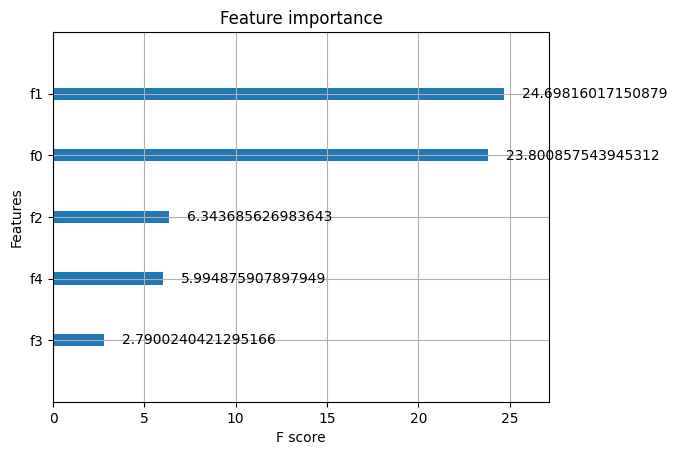

In [94]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
importance = bst.get_score(importance_type='gain')
# Plot feature importance
plot_importance(bst, importance_type='gain')
plt.show()

In [95]:
print(importance.items())
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print("Features ranked by importance:")
for feature, score in sorted_importance:
    print(f"{feature}: {score}")

dict_items([('f0', 23.800857543945312), ('f1', 24.69816017150879), ('f2', 6.343685626983643), ('f3', 2.7900240421295166), ('f4', 5.994875907897949)])
Features ranked by importance:
f1: 24.69816017150879
f0: 23.800857543945312
f2: 6.343685626983643
f4: 5.994875907897949
f3: 2.7900240421295166
